In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Sachin@123",
                             database = "ecommerce")
cur = db.cursor()


# Basic Queries
 ## 1. List all unique cities where customers are located.

In [5]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

## 2. Count the number of orders placed in 2017.

In [23]:
query = """ select count(order_id) from orders where order_purchase_timestamp = 2017 """

cur.execute(query)

data = cur.fetchall()

"total number of order placed in 2017",data[0][0]

('total number of order placed in 2017', 45101)

## 3. Find the total sales per category.

In [18]:
query = """ select products.products_category category, 
             sum(payments.payment_value) sales 
             from products join order_items on
             order_items.product_id = products.product_id
             join payments on
             payments.order_id = order_items.order_id
             group by category 
             """

cur.execute(query)

data = cur.fetchall()

data

ProgrammingError: 1054 (42S22): Unknown column 'products.products_category' in 'field list'

In [20]:
query = """ select products.product_category category, 
             round(sum(payments.payment_value),2) sales 
             from products join order_items on
             order_items.product_id = products.product_id
             join payments on
             payments.order_id = order_items.order_id
             group by category 
             """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])

df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


## 4. Calculate the percentage of orders that were paid in installments.

In [44]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end)) / count(*) * 100
             from payments
             """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is .",data[0][0]

('the percentage of orders that were paid in installments is .',
 Decimal('99.9981'))

## 5. Count the number of customers from each state.

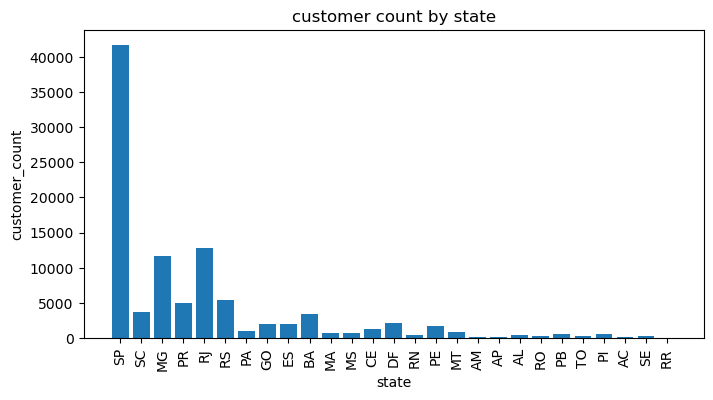

In [22]:
query = """ select count(customer_id), customer_state from customers
            group by customer_state
             """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_count","state"])

plt.figure(figsize = (8,4))
plt.bar(df['state'],df['customer_count'])
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("customer count by state")
plt.xticks(rotation = 90)
plt.show()

## Intermediate Queries
## 1. Calculate the number of orders per month in 2018.

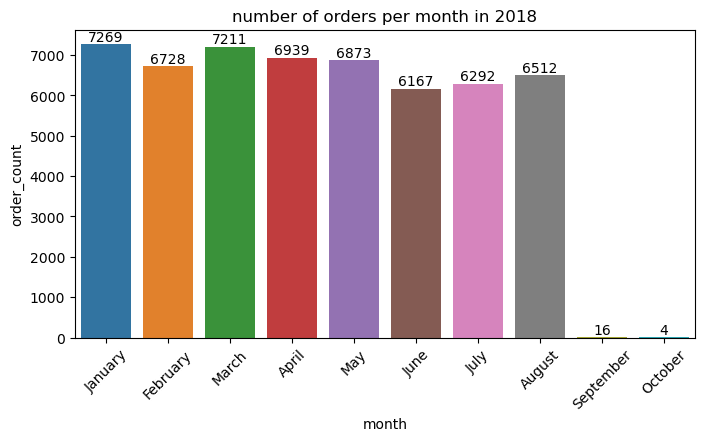

In [38]:
query = """ select count(order_id) order_count, monthname(order_purchase_timestamp) month
             from orders where year(order_purchase_timestamp) = 2018 
             group by month
             """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["order_count","month"])
o = ["January", "February","March","April","May","June","July","August","September","October"]
plt.figure(figsize = (8,4))
ax = sns.barplot(x = df['month'], y= df['order_count'], data =df, order = o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.title("number of orders per month in 2018")
plt.show()

## 2. Find the average number of products per order, grouped by customer city.

In [23]:
query = """ with count_per_order as
          (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
            from orders join order_items 
             on order_items.order_id = orders.order_id 
              group by orders.order_id, orders.customer_id)

             select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
              from customers join count_per_order
              on customers.customer_id = count_per_order.customer_id
              group by customers.customer_city
              order by average_orders desc    ;
             """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "Average product/order"])
df.head(10)                 

,customer city,Average product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


## 3. Calculate the percentage of total revenue contributed by each product category.

In [8]:
 query = """ select products.product_category, 
              round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percent
              from  products join order_items  on
              products.product_id = order_items.product_id
              join payments on
              payments.order_id = order_items.order_id
              group by products.product_category
              order by sales_percent desc;
             """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "sales_percent"])
df.head(10)       

,product_category,sales_percent
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


## 4. Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
query = """ select products.product_category products_category,
            count(order_items.product_id),
            round(avg(order_items.price),2) 
            from products
            join order_items on
            order_items.product_id = products.product_id
            group by products_category
     """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "order_count","price"])
df.head(10)   
arr1 = df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is",a[0][1])


## 5. Calculate the total revenue generated by each seller, and rank them by revenue.


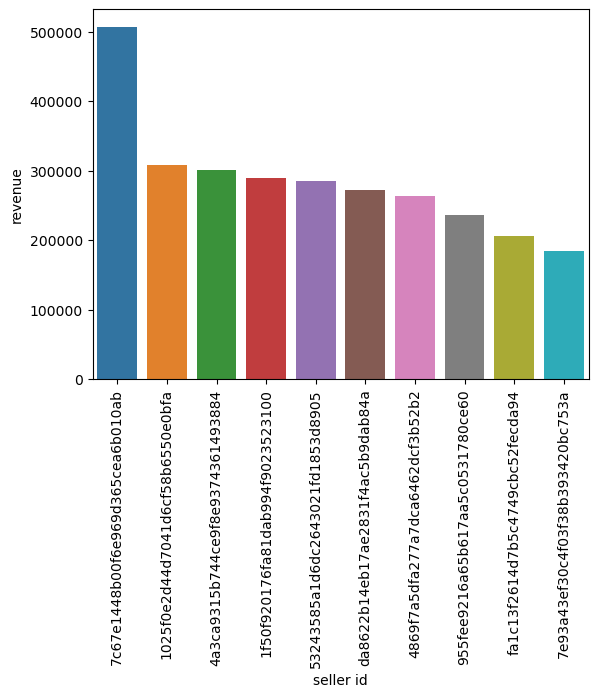

In [39]:
query = """select *, dense_rank() over(order by revenue desc) as rnk from
            (select order_items.seller_id, 
            sum(payments.payment_value) revenue
            from order_items join payments on
            order_items.order_id = payments.order_id
            group by order_items.seller_id) as a 
            """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller id", "revenue","rank"])
df = df.head(10) 
sns.barplot(x = "seller id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries
## 1. Calculate the moving average of order values for each customer over their order history.

In [53]:
query = """    select customer_id, order_purchase_timestamp, payment,
               avg(payment) over(partition by customer_id order by orders.order_purchase_timestamp
               rows between 2 preceding and current row) as moving_avg
               from
               (select orders.customer_id, orders.order_purchase_timestamp,
               payments.payment_value as payment from orders 
               join payments on
               orders.order_id = payments.order_id) as a;
               """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer id", "order purchase timestamp","payment","moving avg"])
df

,customer id,order purchase timestamp,payment,moving avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


## 2. Calculate the cumulative sales per month for each year.

In [60]:
query = """ select years, months, payment, sum(payment)
over(order by years, months) commulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
sum(payments.payment_value) as payment 
from orders join payments on
payments.order_id = orders.order_id 
group by years, months 
order by years, months) as a;

           """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment", "commulative sales"])
df

,years,months,payment,commulative sales
0,2016,9,2.522400e+02,2.522400e+02
1,2016,10,5.909048e+04,5.934272e+04
2,2016,12,1.962000e+01,5.936234e+04
3,2017,1,1.384880e+05,1.978504e+05
4,2017,2,2.919080e+05,4.897584e+05
5,2017,3,4.498636e+05,9.396220e+05
6,2017,4,4.177880e+05,1.357410e+06
7,2017,5,5.929188e+05,1.950329e+06
8,2017,6,5.112764e+05,2.461605e+06
9,2017,7,5.923829e+05,3.053988e+06


## 3. Calculate the year-over-year growth rate of total sales.

In [77]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
         sum(payments.payment_value) as payment 
        from orders join payments on
       payments.order_id = orders.order_id 
        group by years
         order by years)
         select years, ((payment - lag(payment, 1) over(order by years)) / lag(payment, 1) over(order by years))*100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","yoy% growth"])
df

,years,yoy% growth
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [82]:
query = """ with a as (select customers.customer_id,
             min(orders.order_purchase_timestamp) first_order
             from customers join orders
             on customers.customer_id = orders.customer_id
             group by customers.customer_id),
             
             b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
             from a join orders 
             on a.customer_id = orders.customer_id
             and orders.order_purchase_timestamp > first_order
             and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
             group by a.customer_id)

             select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
             from a left join b
             on a.customer_id = b.customer_id;
                                                """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


## 5. Identify the top 3 customers who spent the most money in each year.

AttributeError: 'numpy.int64' object has no attribute 'startswith'

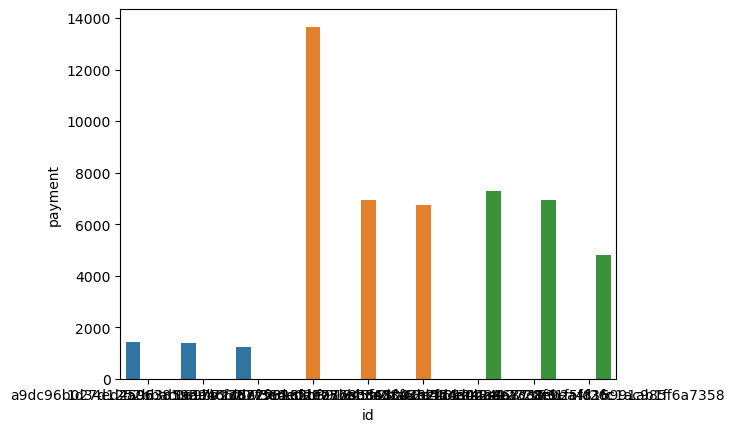

In [104]:
query = """select years, customer_id, payment, d_rank
             from
             (select year(orders.order_purchase_timestamp) years,
             orders.customer_id, 
             sum(payments.payment_value) payment,
             dense_rank() over(partition by year(orders.order_purchase_timestamp)
             order by sum(payments.payment_value) desc) d_rank
             from orders join payments
             on payments.order_id = orders.order_id
             group by year(orders.order_purchase_timestamp),
             orders.customer_id) as a
             where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data =df, hue = "years")
plt.xticks(rotation = 90)
plt.show()